Import necessary libraries 

In [1]:
from apiclient.discovery import build
from flask import request
import pandas as pd
import requests
import json
from pprint import pprint as pp 
import nltk
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates


API_Key From Google Cloud Platform

In [2]:
API_Key="Insert Your API_Key"


Build Youtube API

In [3]:
youtube = build('youtube','v3',developerKey = API_Key)

Calling the API Youtube V3 AND Search query 

In [4]:
Result={'Title':[],"channelTitle":[],"videoId":[],"channelId":[],'publishTime':[],'publishTime':[]}
def getAllVideosId(token): 
    request = youtube.search().list(q='canceling twitter privileges ',
                                    part='snippet',type='video',
                                    maxResults=100,
                                    relevanceLanguage='en',
                                    pageToken=token,
                                    publishedAfter='2022-11-15T00:00:00Z',
                                    regionCode="US")
    res = request.execute()
    print(res) 
    Result['Title']         =   Result['Title']+[w['snippet']['title'] for w in res['items']]
    Result['channelTitle']  =   Result['channelTitle']+[w['snippet']['channelTitle'] for w in res['items']]
    Result['videoId']       =   Result['videoId']+[w['id']['videoId'] for w in res['items']]
    Result['channelId']     =   Result['channelId']+[w['snippet']['channelId'] for w in res['items']]
    Result['publishTime']   =   Result['publishTime']+[w['snippet']['publishTime'] for w in res['items']]

    for item in res['items']:
        if "nextPageToken" in res: 
            return getAllVideosId(res['nextPageToken'])
    
    return Result

Calling to the function getAllVideosId

In [ ]:
Collection_video=getAllVideosId('')

Save Data [title video,videoId,channelTitle,channelId,publishTime] into DataFrame

In [6]:

Result=pd.DataFrame(Collection_video).set_index('Title')
Result.to_csv("./DataVideo.csv")

Import VideoId From Data.csv To collect comments From Youtube

In [3]:
VideoDet = pd.read_csv(r'./DataVideo.csv')
VideoDet = VideoDet.set_index('Title')

Recuperate all column of videoId From DataVideo.csv

In [4]:
VideosId=[w for w in VideoDet["videoId"]]
pp(len(VideosId))

300


Dictionary For organize Data

In [9]:
Result={'id_Comment':[],"Comment":[],"authorChannelUrl":[],'authorChannelId':[],
        'authorDisplayName':[],'likeCount':[],"publishedAt":[]
        }   
AllComment={'id_Comment':[],"Comment":[],"authorChannelUrl":[],'authorChannelId':[],
        'authorDisplayName':[],'likeCount':[],"publishedAt":[]
        } 

Calling the API Youtube V3 AND collect comments of Videos 

In [6]:

def getAllTopLevelComment(token,VId): 
    request = youtube.commentThreads().list(part='snippet',
                                            videoId=VId,
                                            textFormat='plainText',
                                            order="relevance",
                                            maxResults=100,
                                            pageToken=token)
    res = request.execute()
    
    Result['id_Comment']        = Result['id_Comment']+[w['snippet']['topLevelComment']['id'] for w in res['items']]
    Result['Comment']           = Result['Comment']+[w['snippet']['topLevelComment']['snippet']['textOriginal'] for w in res['items']]
    Result['authorChannelUrl']  = Result['authorChannelUrl']+[w['snippet']['topLevelComment']['snippet']['authorChannelUrl'] for w in res['items']]
    Result['authorChannelId']   = Result['authorChannelId']+[w['snippet']['topLevelComment']['snippet']['authorChannelId']['value'] for w in res['items']]
    Result['authorDisplayName'] = Result['authorDisplayName']+[w['snippet']['topLevelComment']['snippet']['authorDisplayName'] for w in res['items']]
    Result['likeCount']         = Result['likeCount']+[w['snippet']['topLevelComment']['snippet']['likeCount'] for w in res['items']]
    Result['publishedAt']       = Result['publishedAt']+[w['snippet']['topLevelComment']['snippet']['publishedAt'] for w in res['items']]

    for item in res['items']:
        if "nextPageToken" in res: 
            return getAllTopLevelComment(res['nextPageToken'],VId)
    
    return Result

This for recuperate all comment in for each video in DataVideo.csv

In [ ]:
for VideoId in  VideosId :
    Resu=getAllTopLevelComment('',VideoId)
    AllComment['id_Comment']=AllComment['id_Comment']+Resu['id_Comment']
    AllComment['Comment']=AllComment['Comment']+Resu['Comment']
    AllComment['authorChannelUrl']=AllComment['authorChannelUrl']+Resu['authorChannelUrl']
    AllComment['authorChannelId']=AllComment['authorChannelId']+Resu['authorChannelId']
    AllComment['authorDisplayName']=AllComment['authorDisplayName']+Resu['authorDisplayName']
    AllComment['likeCount']=AllComment['likeCount']+Resu['likeCount']
    AllComment['publishedAt']=AllComment['publishedAt']+Resu['publishedAt']


Save all collected comments into DataComments.csv

In [ ]:
Result2=pd.DataFrame(AllComment).set_index('id_Comment')
Result2.to_csv("./DataComments.csv")


Read DataComment From CSVFile

In [2]:
DataComment = pd.read_csv(r'./DataComments.csv')
DataComment = DataComment.set_index('id_Comment')

Filtering Data

In [3]:
KeyWordsTopic=["Elon Musk's","Twitter","rejoined","joined","Elon","musk","subscribe","money","tweet","followers","account","deactivate","password",
                "social", "media"]

Import positive And Negative words

In [4]:
positive_words=[(w.strip()) for w in open("./opinion-lexicon-English/positive-words.txt", "r")]
negative_words=[(w.strip()) for w in open("./opinion-lexicon-English/negative-words.txt", "r")]


NormalizeText with regularExpression

In [5]:
# import regex
import re
 
# import nltk for stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def NormlizeComment(Comment):
    # convert to lower case
    lower_string = Comment.lower()
    # remove numbers
    no_number_string = re.sub(r'\d+','',lower_string)
    # add space after punctuation
    no_punc_string = re.sub(r'[^\w\s]','', no_number_string)
    # remove white spaces
    no_wspace_string = no_punc_string.strip()
    # no_wspace_string
    # convert string to list of words
    lst_string = [no_wspace_string][0].split() 
    # remove stopwords
    no_stpwords_string=""
    for i in lst_string:
        if not i in stop_words:
            no_stpwords_string += i+' '     
    # removing last space
    no_stpwords_string = no_stpwords_string[:-1]
 
    return no_stpwords_string


Positive AND Negative words to string for using in RegularExpression

In [30]:
PW = '|'.join(map(str, positive_words))
NW = '|'.join(map(str, negative_words))
KeyWT='|'.join(map(str, KeyWordsTopic))


Function For return Positive And Negativ words For each comment Using Regexp

In [33]:
def extract_PN_Words(comment,PW,NW):
    r = re.compile(r"PW", flags=re.I | re.X)
    Positive=re.findall(PW,comment)
    r = re.compile(r"NW", flags=re.I | re.X)
    Negative=re.findall(NW,comment)
    return Positive,Negative

verify Existing words Topic

In [38]:
def existing_KWT(comment,KWT):
     r = re.compile(r"KWT", flags=re.I | re.X)
     arr=re.findall(KWT,comment)
     if (len(arr)==0):
        return False
     else: 
        return True               


Initialize Dictionary For Orgnize Data statistiques

In [9]:
CommentsDetails={"Comments":[],"Positive_Words":[],"length_Positive_Words":[],"Negative_Words":[],"length_Negative_Words":[],"DatePublish":[],"class":[]}

In [10]:
print(len(DataComment['Comment']))
print(len(DataComment['Comment']))

216306
216306


Filter Founded Comment in youtube

In [41]:

# CommentsDetails['DatePublish']=DataComment['publishedAt']
for item,row in DataComment.iterrows():
        if (existing_KWT(row["Comment"],KeyWT)):
            pos,neg=extract_PN_Words(NormlizeComment(row["Comment"]),PW,NW)
            CommentsDetails['DatePublish'].append(row["publishedAt"])
            CommentsDetails['Comments'].append(row["Comment"])
            CommentsDetails['Positive_Words'].append(pos)
            CommentsDetails['length_Positive_Words'].append(len(pos))
            CommentsDetails['Negative_Words'].append(neg)
            CommentsDetails['length_Negative_Words'].append(len(neg))  
            if(len(neg)>len(pos)) :
                CommentsDetails['class'].append("negative")   
            else:
                CommentsDetails['class'].append("Positive")   

Save Data into file StatistiquesPN.csv

In [43]:
Result3=pd.DataFrame(CommentsDetails).set_index('Comments')
Result3.to_csv("./StatistiquesPN.csv")
print(len(CommentsDetails['Comments']))

15595


StatistiquesPN.csv

In [44]:
Statistique = pd.read_csv(r'./StatistiquesPN.csv')
Statistique = Statistique.set_index('Comments')
Statistique = Statistique.sort_values(by=['DatePublish'])

In [45]:
i=0
for data in Statistique['DatePublish']:
    Statistique['DatePublish'][i]=data.split('T')[0]
    i=i+1

In [46]:
pp(len(Statistique['DatePublish']))

15595


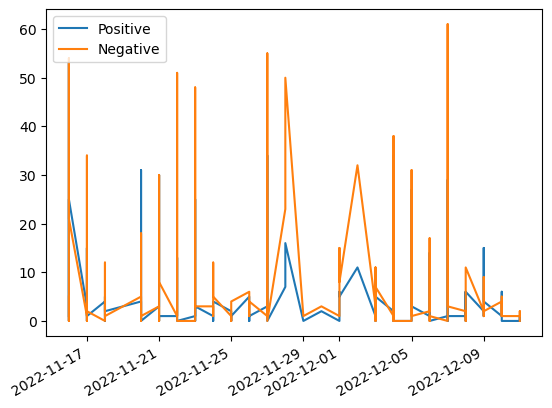

In [47]:
date_time = Statistique['DatePublish']
date_time = pd.to_datetime(date_time)
data = Statistique['length_Positive_Words']
data2 = Statistique['length_Negative_Words']

fig, ax = plt.subplots()
ax.plot(date_time,data, label="Positive")
ax.plot(date_time,data2, label="Negative")
ax.legend()

plt.gcf().autofmt_xdate()
plt.show()


In [48]:
len(Statistique['class'])
positiveClass=[]
negativeClass=[]
for item in range(len(Statistique['class'])):
    if 'Positive' in Statistique['class'][item]:
        positiveClass.append({'class':Statistique['length_Positive_Words'][item],'Date':Statistique['DatePublish'][item]})
    else:
        negativeClass.append({'class':Statistique['length_Negative_Words'][item],'Date':Statistique['DatePublish'][item]})

Positive Plot

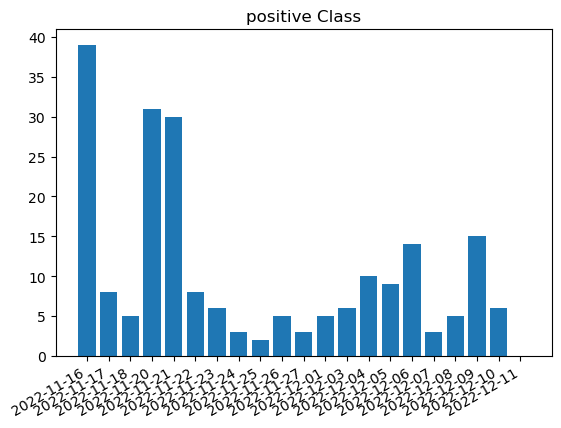

In [49]:
date_time = [w['Date'] for w in positiveClass]
# date_time = pd.to_datetime(date_time)
data = [w['class'] for w in positiveClass]
plt.bar(date_time,data)
plt.title("positive Class")
plt.gcf().autofmt_xdate()
plt.show()

NegativeClassPlot

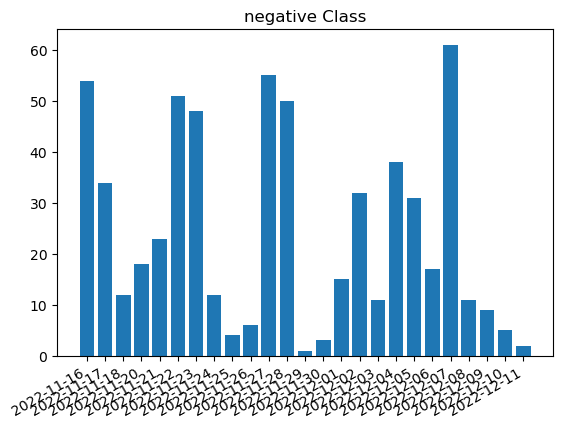

In [50]:
date_time = [w['Date'] for w in negativeClass]
# date_time = pd.to_datetime(date_time)
data = [w['class'] for w in negativeClass]
plt.bar(date_time,data)
plt.title("negative Class")

plt.gcf().autofmt_xdate()
plt.show()

In [54]:
# canceling twitter privileges     query
if (len(negativeClass)>len(positiveClass)):
    print("negative opinion")
else:
    print("positive opinion")

negative opinion
